In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os 

import wandb
import boto3
import torch
import matplotlib.pyplot as plt

from mogwai import models
from mogwai.utils.functional import apc
from mogwai.plotting import (
    plot_colored_preds_on_trues,
    plot_precision_vs_length,
)

s3 = boto3.client("s3")
s3_bucket = "proteindata"


api = wandb.Api()


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
    "font.size": 8,
})


In [3]:
fatt_model = models.get('factored_attention')
gremlin_model = models.get('gremlin')

In [4]:
def download_statedict(run_id, dest='fatt.h5'):
    run = api.run(f"{entity}/{project}/{run_id}")
    key = os.path.join("iclr-2021-factored-attention", *run.path, "model_state_dict.h5")
    with open(dest, 'wb') as f:
        s3.download_fileobj(s3_bucket, key, f)
    return dest

In [30]:
# potts 3n2a_1_A
# plt.subplots(figsize=(6/4.0, 6/4.0), ncols=4, dpi=600)

entity, project, run_id = 'proteins/iclr2021-rebuttal/5p63zkjd'.split('/')
run = api.run(f"{entity}/{project}/{run_id}")

gremlin_sd = download_statedict(run_id, dest='gremlin.h5')

hparams = {}
hparams['msa_length'] = run.config['msa_length']
hparams['num_seqs'] = run.config['num_seqs']
hparams['true_contacts'] = torch.ones([hparams['msa_length'], hparams['msa_length']])
model = gremlin_model(**hparams)

model.load_state_dict(torch.load(gremlin_sd))

<All keys matched successfully>

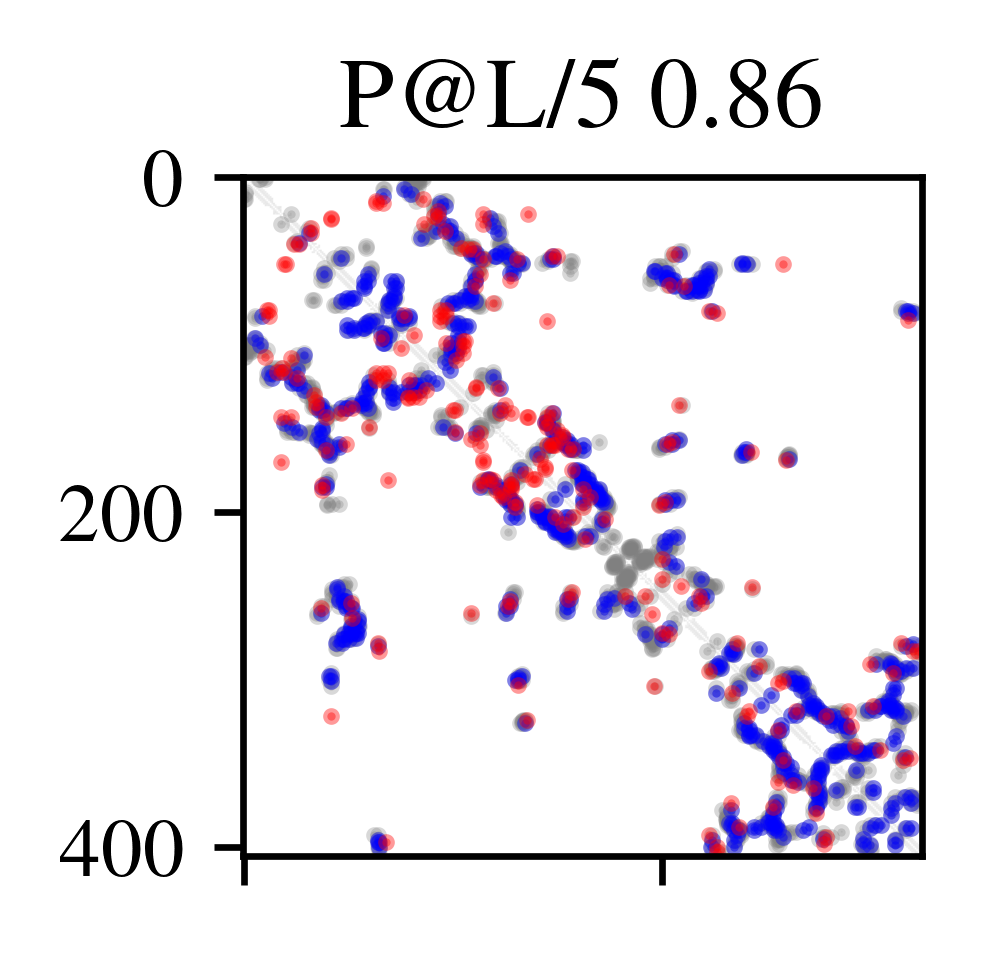

In [38]:
# TODO  L/5
fig, ax = plt.subplots(figsize=(6/4.0, 6/4.0), ncols=1, nrows=1, dpi=600)
plot_colored_preds_on_trues(apc(model.get_contacts()), model._true_contacts, point_size=1, cutoff=1)
cutoff=5
ax.set_title(f"P@L/{cutoff} {model.get_precision(do_apc=True, cutoff=cutoff):.2f}")
ax.set_xticklabels([])
plt.savefig('contact_potts_3n2a_1_A.pdf', dpi=600, bbox_inches="tight")

In [7]:
# fatt 2bfw
fatt_2bfw_runid = 'proteins/iclr2021-rebuttal/hfefy7co'.split('/')[-1]
run_id = fatt_2bfw_runid
run = api.run(f"{entity}/{project}/{run_id}")
sd = download_statedict(run_id, dest='fatt.h5')

hparams = {}
hparams['msa_length'] = run.config['msa_length']
hparams['num_seqs'] = run.config['num_seqs']
hparams['num_attention_heads'] = run.config['num_attention_heads']
hparams['attention_head_size'] = run.config['attention_head_size']
hparams['true_contacts'] = torch.ones([hparams['msa_length'], hparams['msa_length']])
model = fatt_model(**hparams)

model.load_state_dict(torch.load(sd))
fatt_2bfw = model

Text(0.5, 1.0, 'P@L 0.71')

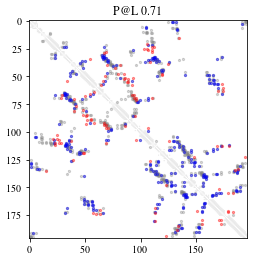

In [8]:
plot_colored_preds_on_trues(apc(model.get_contacts()), model._true_contacts, point_size=5, cutoff=1)
plt.title(f"P@L {model.get_precision(do_apc=True):.2f}")

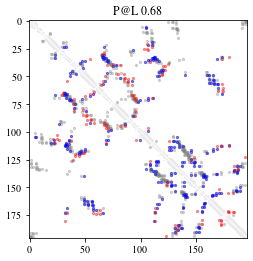

In [24]:
# potts 2bfw
# entity, project, run_id = 'proteins/iclr2021-rebuttal/qwifi0ww'.split('/') # learning rate 0.1
entity, project, run_id = 'proteins/iclr2021-rebuttal/re061sfb'.split('/') # learning rate 0.5

run = api.run(f"{entity}/{project}/{run_id}")

gremlin_sd = download_statedict(run_id, dest='gremlin.h5')

hparams = {}
hparams['msa_length'] = run.config['msa_length']
hparams['num_seqs'] = run.config['num_seqs']
hparams['true_contacts'] = torch.ones([hparams['msa_length'], hparams['msa_length']])
model = gremlin_model(**hparams)

model.load_state_dict(torch.load(gremlin_sd))

plot_colored_preds_on_trues(apc(model.get_contacts()), model._true_contacts, point_size=5, cutoff=1)
plt.title(f"P@L {model.get_precision(do_apc=True):.2f}")
potts_2bfw = model

In [10]:
# protbert bfd 2bfw
run = api.run(f'proteins/gremlin-contacts/btdgy7c6')
runfilenames = ['predicted_contacts.npy', 'true_contacts.npy']
runfiles = run.files(names=runfilenames)
for runfile in runfiles:
    runfile.download(replace=True)
    
import numpy as np
with open(runfilenames[0], 'rb') as f:
    predicted_contacts = torch.Tensor(np.load(f))

with open(runfilenames[1], 'rb') as f:
    true_contacts = torch.Tensor(np.load(f))
    
from mogwai.metrics import precision_at_cutoff

protbert_predicted = predicted_contacts
# plot_colored_preds_on_trues(apc(predicted_contacts), true_contacts, point_size=5, cutoff=1)
# plt.title(f"P@L {precision_at_cutoff(apc(predicted_contacts), true_contacts):.2f}")


In [11]:
# single layer attention 2bfw
run = api.run(f'proteins/gremlin-contacts/so2qo7yl')
runfilenames = ['predicted_contacts.npy', 'true_contacts.npy']
runfiles = run.files(names=runfilenames)
for runfile in runfiles:
    runfile.download(replace=True)
    
import numpy as np
with open(runfilenames[0], 'rb') as f:
    predicted_contacts = torch.Tensor(np.load(f))

with open(runfilenames[1], 'rb') as f:
    true_contacts = torch.Tensor(np.load(f))
    
from mogwai.metrics import precision_at_cutoff

satt_predicted = predicted_contacts
# plot_colored_preds_on_trues(apc(predicted_contacts), true_contacts, point_size=5, cutoff=1)
# plt.title(f"P@L {precision_at_cutoff(apc(predicted_contacts), true_contacts):.2f}")

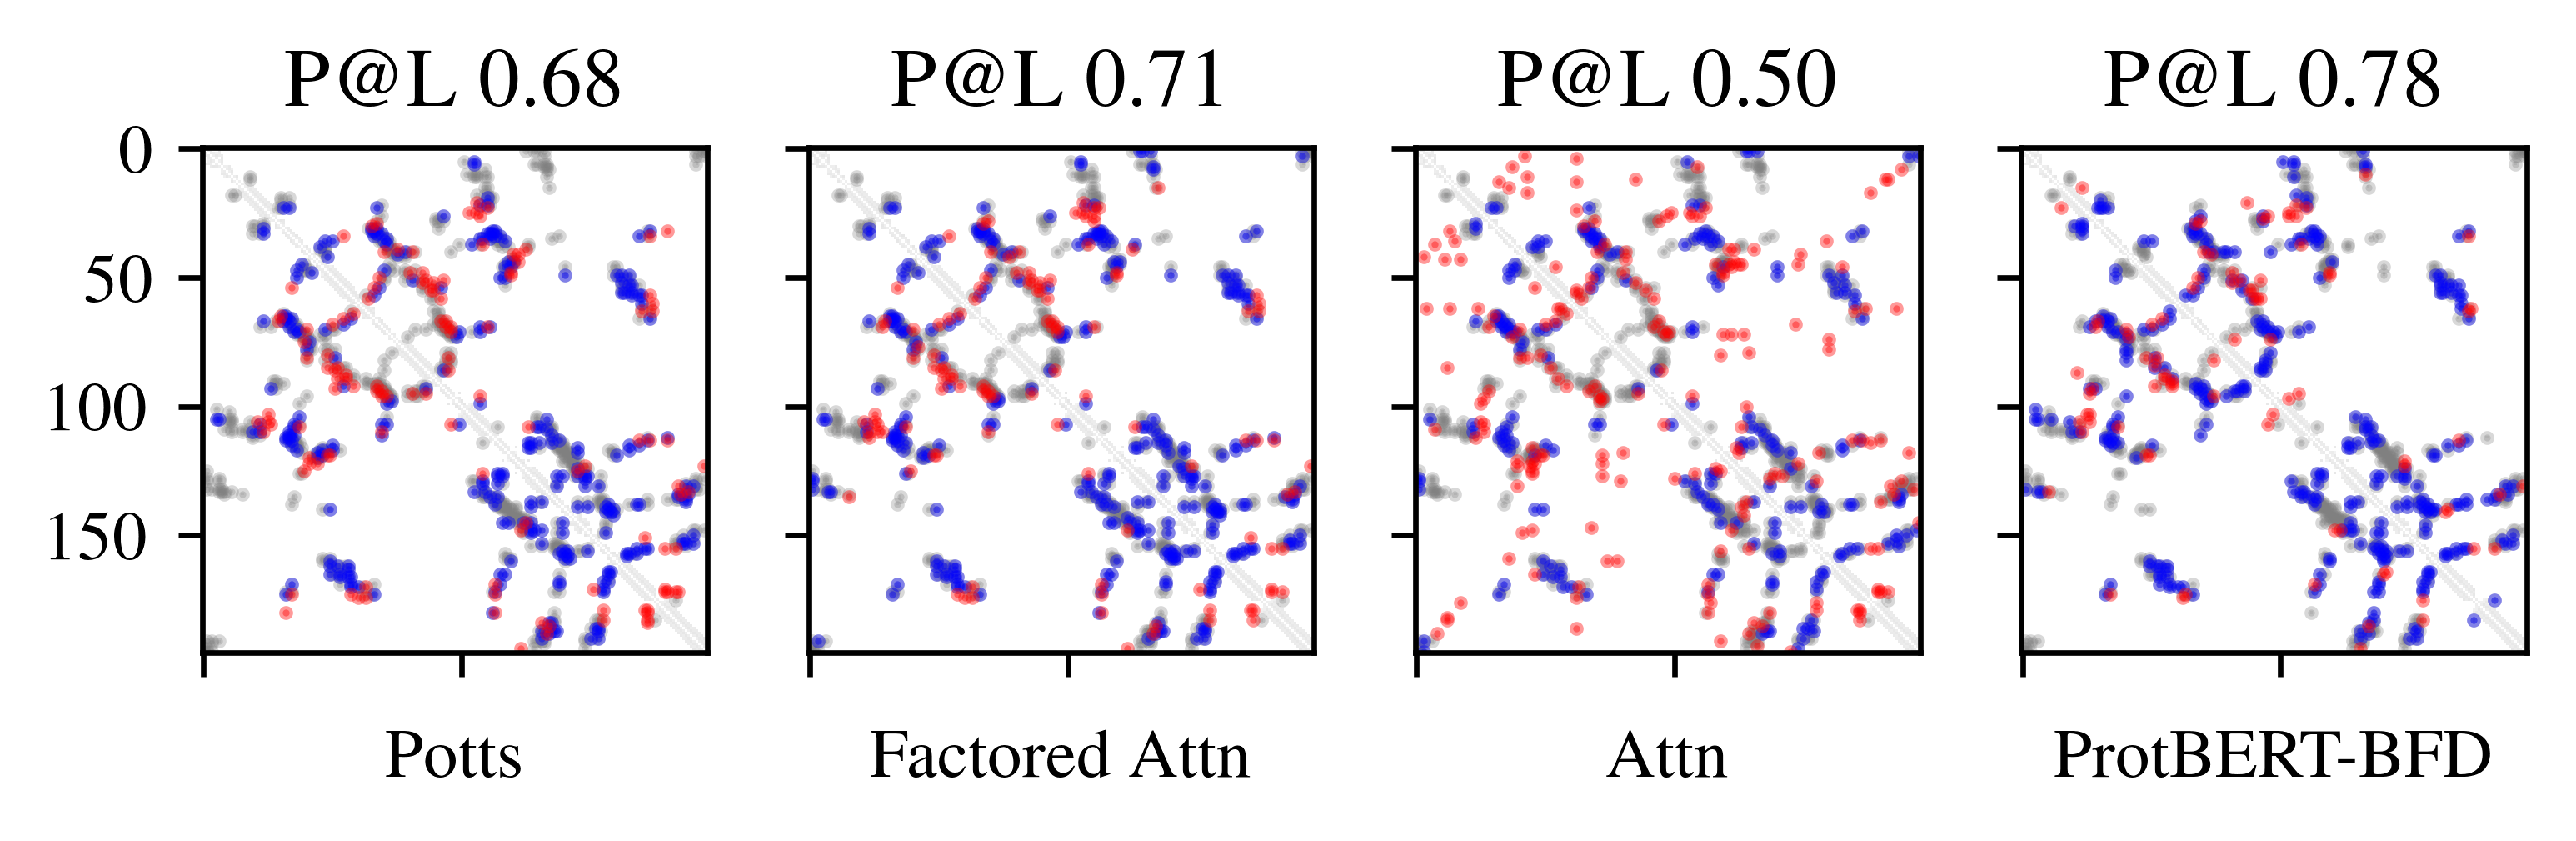

In [25]:
fig, ax = plt.subplots(figsize=(6, 6/4.0), ncols=4, dpi=600, sharey=True, sharex=True)

point_size = 1

cur_ax = ax[0]
plot_colored_preds_on_trues(apc(potts_2bfw.get_contacts()), potts_2bfw._true_contacts, point_size=point_size, cutoff=1, ax=cur_ax)
cur_ax.set_title(f"P@L {potts_2bfw.get_precision(do_apc=True):.2f}")
cur_ax.set_xlabel('Potts')
cur_ax.set_xticklabels([])

cur_ax = ax[1]
plot_colored_preds_on_trues(apc(fatt_2bfw.get_contacts()), fatt_2bfw._true_contacts, point_size=point_size, cutoff=1, ax=cur_ax)
cur_ax.set_title(f"P@L {fatt_2bfw.get_precision(do_apc=True):.2f}")
cur_ax.set_xlabel('Factored Attn')
cur_ax.set_xticklabels([])

cur_ax = ax[2]
plot_colored_preds_on_trues(apc(satt_predicted), true_contacts, point_size=point_size, cutoff=1, ax=cur_ax)
cur_ax.set_title(f"P@L {precision_at_cutoff(apc(satt_predicted), true_contacts):.2f}")
cur_ax.set_xlabel('Attn')
cur_ax.set_xticklabels([])

cur_ax = ax[3]
plot_colored_preds_on_trues(apc(protbert_predicted), true_contacts, point_size=point_size, cutoff=1, ax=cur_ax)
cur_ax.set_title(f"P@L {precision_at_cutoff(apc(protbert_predicted), true_contacts):.2f}")
cur_ax.set_xlabel('ProtBERT-BFD')
cur_ax.set_xticklabels([])

plt.yticks([0, 50, 100, 150])
plt.savefig('contact_maps_2bfw.pdf', dpi=600, bbox_inches="tight", pad_inches=0.1)

In [14]:
protbert_predicted.shape

torch.Size([196, 196])